# 🔐 Enhanced Intrusion Detection System using Autoencoders
This notebook builds on my previous results and adds:
- Reconstruction error visualization
- Optimal threshold tuning using ROC analysis
- ROC and PR curves
- Improved evaluation

In [13]:
# Step 1: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

In [14]:
# Step 2: Load the dataset
df = pd.read_csv("UNSW-NB15P-MM-SAMPLE.csv")

In [15]:
# Step 3: Preprocessing and Splitting
Dn = df[df['Class'] == 0].drop(columns=['Class'])
Da = df[df['Class'] == 1].drop(columns=['Class'])
Dntr, Dnts = train_test_split(Dn, test_size=0.2, random_state=42)
Dts = pd.concat([Dnts, Da], ignore_index=True)
Dts_labels = [0]*len(Dnts) + [1]*len(Da)

In [16]:
# Step 4: Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(Dntr)
X_test = scaler.transform(Dts)

In [17]:
# Step 5: Autoencoder Definition
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation="relu")(input_layer)
encoded = Dense(32, activation="relu")(encoded)
encoded = Dense(16, activation="relu")(encoded)
decoded = Dense(32, activation="relu")(encoded)
decoded = Dense(64, activation="relu")(decoded)
output_layer = Dense(input_dim, activation="linear")(decoded)
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')

In [18]:
# Step 6: Training
autoencoder.fit(X_train, X_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_split=0.1,
                verbose=1)

Epoch 1/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 1s 922us/step - loss: 0.3982 - val_loss: 0.0837
Epoch 2/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 1s 647us/step - loss: 0.0780 - val_loss: 0.0527
Epoch 3/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 1s 612us/step - loss: 0.0640 - val_loss: 0.0375
Epoch 4/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 1s 608us/step - loss: 0.0379 - val_loss: 0.0275
Epoch 5/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 1s 609us/step - loss: 0.0279 - val_loss: 0.0221
Epoch 6/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 1s 623us/step - loss: 0.0248 - val_loss: 0.0204
Epoch 7/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - loss: 0.0221 - val_loss: 0.0173
Epoch 8/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step - loss: 0.0183 - val_loss: 0.0193
Epoch 9/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step - loss: 0.0242 - val_loss: 0.0149
Epoch 10/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step - loss: 0.0166 - val_loss: 0.0142
Epoch 11/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - loss: 0.0155 - val_loss: 0.0183
Epoch 12/20
965/965 ━━━━━━━━━━

In [19]:
# Step 7: Predictions and Errors
X_train_pred = autoencoder.predict(X_train)
X_test_pred = autoencoder.predict(X_test)
train_errors = np.mean(np.square(X_train - X_train_pred), axis=1)
test_errors = np.mean(np.square(X_test - X_test_pred), axis=1)
test_errors = np.clip(test_errors, a_min=0.001, a_max=None)

8570/8570 ━━━━━━━━━━━━━━━━━━━━ 1s 172us/step
2837/2837 ━━━━━━━━━━━━━━━━━━━━ 0s 170us/step


In [20]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(Dts_labels, test_errors)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1)
best_threshold = thresholds[best_idx]
predicted_labels = (test_errors > best_threshold).astype(int)

In [21]:
# Step 9: Evaluation
print("Best Threshold:", best_threshold)
print("Train Mean Error:", np.mean(train_errors))
print("Test Mean Error:", np.mean(test_errors))
print("\nConfusion Matrix:\n", confusion_matrix(Dts_labels, predicted_labels))
print("\nClassification Report:\n", classification_report(Dts_labels, predicted_labels))
print("\nROC-AUC Score:", roc_auc_score(Dts_labels, test_errors))

Best Threshold: 0.03724340539741518
Train Mean Error: 0.012076034068568126
Test Mean Error: 0.2921719175789945

Confusion Matrix:
 [[64438  4119]
 [  583 21632]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.96     68557
           1       0.84      0.97      0.90     22215

    accuracy                           0.95     90772
   macro avg       0.92      0.96      0.93     90772
weighted avg       0.95      0.95      0.95     90772


ROC-AUC Score: 0.989003912232063


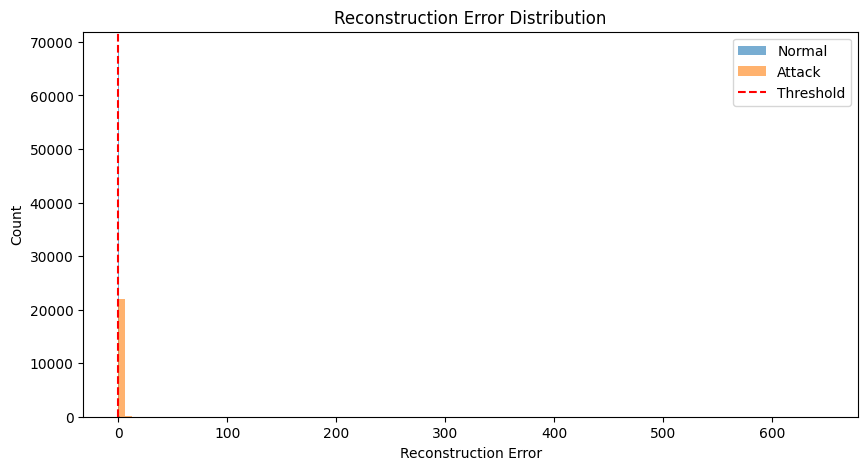

/var/folders/2t/h5vxtfps26v6vvwwrnpmvhg00000gn/T/ipykernel_70156/1284560561.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


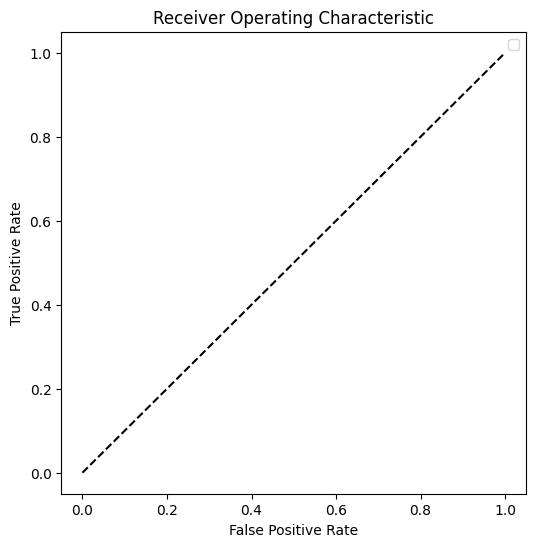

In [22]:
# Step 10: Visualizations
plt.figure(figsize=(10, 5))
plt.hist(test_errors[:len(Dnts)], bins=100, alpha=0.6, label='Normal')
plt.hist(test_errors[len(Dnts):], bins=100, alpha=0.6, label='Attack')
plt.axvline(best_threshold, color='red', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
# plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()